# MRF - development

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("..")) # so we can find didson.py, multibeam.py

from glob import glob           # file manipulation
import numpy as np
from skimage.io import imread,imsave  # image processing
from scipy.optimize import curve_fit
from scipy.stats import *       # stats utils

from matplotlib import rcParams 
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
# print rcParams['font.size']

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sonar import Sonar
from didson import Didson

didson = Didson();
didson.loadConfig('../data/DIDSON/didson.json')
print 'Pings are',didson.num_beams,'beams by',didson.num_bins, 'bins'
print 'Field of view:', didson.fov
print 'Range:', didson.min_range, ' - ', didson.max_range, 'm.'
print 'Noise:', didson.noise
print 'RX gain:', didson.rx_gain,'dB'

Pings are 96 beams by 512 bins
Field of view: 0.502654824574
Range: 2.25  -  11.25 m.
Noise: 0.002
RX gain: 20.0 dB


In [3]:
test_image_list = sorted(glob('../data/test/*.png')) # window set to 2.25m to 11.25m
test_config_list = sorted(glob('../data/test/*.json'))
print len(test_image_list),'image files,', len(test_config_list),'config files'

# for i in range(0,len(test_image_list)):
#     print(test_image_list[i])
#     print(test_config_list[i])
#     print(' ')

10 image files, 10 config files


In [4]:
import utils

## Simulated Annealing

[ 0.30971873  0.0100861   0.02272122  0.19141187]


(-0.5, 511.5, 95.5, -0.5)

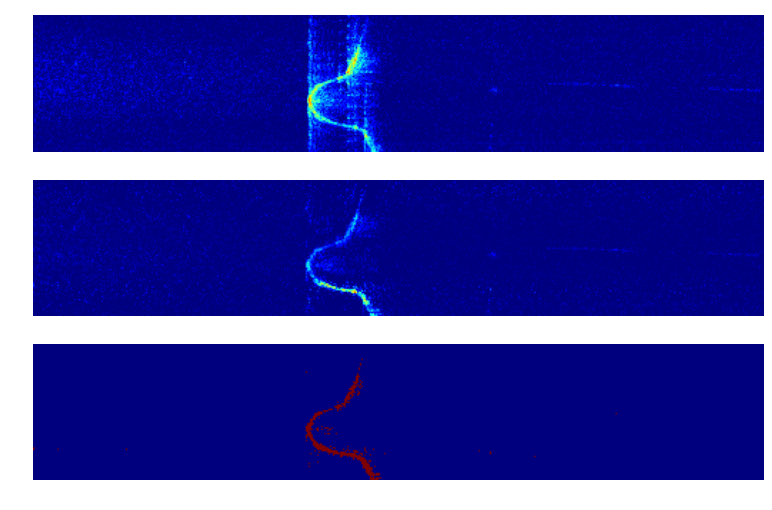

In [153]:
idx = 9
image = (1/255.0)*imread(test_image_list[idx],as_grey = True)
didson.loadConfig(test_config_list[idx])
didson.noise=0.001
image_d = didson.deconvolve(image)
image_d = didson.removeTaper(image_d)

(p,k) = utils.getMixtureParameters(image_d)
print p
image_bin = utils.segment_map(image_d, p[0],p[1],p[2],p[3])

plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.imshow(image.transpose(),vmin=0,vmax=1)
plt.axis('off')
plt.subplot(3,1,2)
plt.imshow(image_d.transpose(), vmin=0, vmax=1)
plt.axis('off')
plt.subplot(3,1,3)
plt.imshow(image_bin.transpose(), vmin=0, vmax=1)
plt.axis('off')

In [121]:
def clique_cost(img_bin, i, j,m=1):
    # compute cost if central pixel is 0 and cost if central pixel is 1
    c0 = 0
    c1 = 0
    
    for k in range( max(i-m,0),min(i+m+1,R)):
        for l in range( max(j-m,0), min(j+m+1,C)):
            if (i!=k or j!=l):
                if img_bin[k,l]==0:
                    c1+=1.0
                else:
                    c0+=1.0
    return (c0, c1)

450.0
-109.0
9


/home/pvt/anaconda2/envs/multibeam/lib/python2.7/site-packages/skimage/io/_io.py:132: UserWarning: mrf_9.png is a low contrast image
  warn('%s is a low contrast image' % fname)


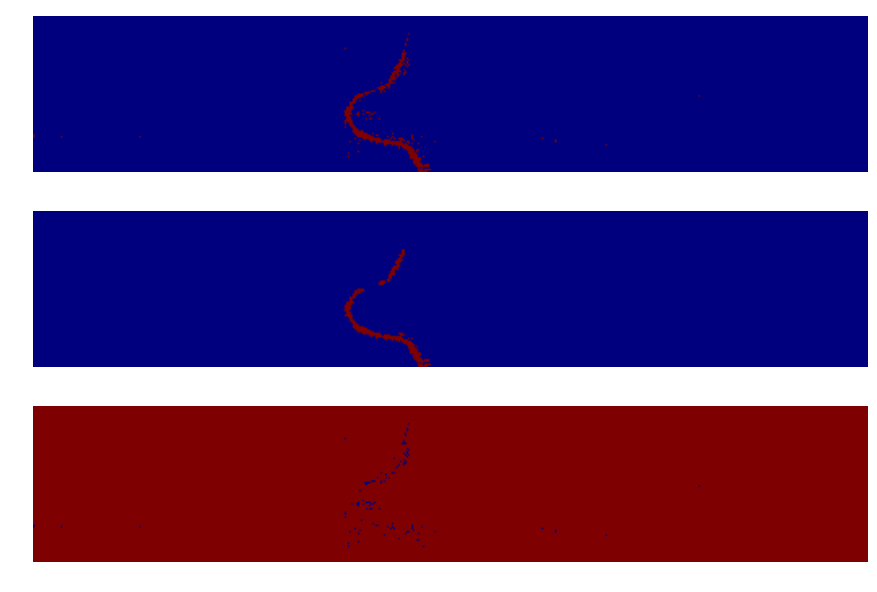

In [154]:
(R,C) = image_d.shape
beta = 0.5;

out = np.array(image_bin, copy=True)  
T0 = 4

pi_exp = p[0]/(1-p[1])
pi2 = p[1]
# SA

(il,jl) = np.nonzero(image_bin)

print np.sum(image_bin.flatten())
for k in range(2,10000):
    
    temp = T0/np.log(k)
    
    # get the site we are going to flip
    l = np.random.randint(0,len(il))
    i = il[l]
    j = jl[l]

    y = image_d[i,j]   # current intensity
    if 0==y:
        continue # it must certainly be x=0
    x = out[i,j]       # current state

    (c0,c1) = clique_cost(out,i,j,1)
#     p0 = (1-pi2)*utils.background_pmf(y, pi_exp, p[2])
#     p1 = pi2*utils.object_pmf(y, p[3])
    e0 = -np.log((1-pi2)*utils.background_pmf(y, pi_exp, p[2])) + beta*c0
    e1 = -np.log(pi2*utils.object_pmf(y, p[3])) + beta*c1
    
#     print y,e0,e1
    if (e1<e0):
        out[i,j]=1.0
    else:
        out[i,j]=0.0
            
#     if(delta<0):
#         out[i,j] = 1 - out[i,j] # flip
#         print 'flipped',i,j
#     else:
#         r = np.random.rand(1)[0]
#         if r < np.exp(-delta/temp):
#             out[i,j] = 1 - out[i,j] # flip

plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.imshow(image_bin.transpose(),vmin=0, vmax=1)
plt.axis('off')
plt.subplot(3,1,2)
plt.imshow(out.transpose(),vmin=0, vmax=1)
plt.axis('off')
plt.subplot(3,1,3)
diff = out-image_bin
plt.imshow(diff.transpose())
plt.axis('off')
plt.tight_layout()
print np.sum(out.flatten())-np.sum(image_bin.flatten())

img_out = (255*(1-out.transpose()))
imsave('mrf_'+str(idx)+'.png',img_out.astype(np.uint8))
print idx

In [79]:
def disp_idx(i,j,R,C):
    for k in range( max(i-1,0),min(i+2,R)):
        for l in range( max(j-1,0), min(j+2,C)):
            if (i!=k or j!=l):
                print k,l
    
disp_idx(1,1,512,96)
np.random.rand(1)[0]

0 0
0 1
0 2
1 0
1 2
2 0
2 1
2 2


0.37687544003499773